# 1. Imports

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras import layers, models #type: ignore
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# 2. Load Data

In [ ]:
df = pd.read_csv("../data/raw/merged-stock-data.csv")
print("Available columns:", df.columns.tolist())
print(f"Initial data shape: {df.shape}")

def add_advanced_technical_features(df):
    """Add advanced technical indicators used by professional traders"""
    df = df.copy()
    
    # Basic technical features
    df['ma_5'] = df['close'].rolling(5).mean()
    df['ma_20'] = df['close'].rolling(20).mean()
    df['price_change'] = df['close'].pct_change()
    df['volatility'] = df['close'].rolling(10).std()
    df['hl_spread'] = (df['high'] - df['low']) / df['close']
    df['oc_spread'] = (df['close'] - df['open']) / df['open']
    
    # Advanced momentum indicators
    df['rsi'] = calculate_rsi(df['close'], 14)
    df['macd'], df['macd_signal'] = calculate_macd(df['close'])
    df['bb_upper'], df['bb_lower'], df['bb_width'] = calculate_bollinger_bands(df['close'])
    
    # Volume-based indicators (if volume available)
    if 'Volume' in df.columns:
        df['volume_sma'] = df['Volume'].rolling(20).mean()
        df['volume_ratio'] = df['Volume'] / df['volume_sma']
        df['vwap'] = calculate_vwap(df)
    
    # Support/Resistance levels
    df['support'], df['resistance'] = calculate_support_resistance(df)
    
    # Market structure
    df['higher_high'] = calculate_higher_highs(df['high'])
    df['lower_low'] = calculate_lower_lows(df['low'])
    
    return df.dropna()

def calculate_rsi(prices, period=14):
    """Calculate Relative Strength Index"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD indicator"""
    ema_fast = prices.ewm(span=fast).mean()
    ema_slow = prices.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal).mean()
    return macd, macd_signal

def calculate_bollinger_bands(prices, period=20, std_dev=2):
    """Calculate Bollinger Bands"""
    sma = prices.rolling(period).mean()
    std = prices.rolling(period).std()
    upper = sma + (std * std_dev)
    lower = sma - (std * std_dev)
    width = (upper - lower) / sma
    return upper, lower, width

def calculate_vwap(df):
    """Calculate Volume Weighted Average Price"""
    if 'Volume' in df.columns:
        return (df['close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    return pd.Series(index=df.index, dtype=float)

def calculate_support_resistance(df, window=20):
    """Calculate support and resistance levels"""
    support = df['low'].rolling(window).min()
    resistance = df['high'].rolling(window).max()
    return support, resistance

def calculate_higher_highs(highs, period=5):
    """Detect higher highs pattern"""
    return highs > highs.shift(1).rolling(period).max()

def calculate_lower_lows(lows, period=5):
    """Detect lower lows pattern"""
    return lows < lows.shift(1).rolling(period).min()

print("Adding advanced technical features...")
df = add_advanced_technical_features(df)

feature_cols = [
    "open", "high", "low", "close",
    "ma_5", "ma_20", "price_change", "volatility", "hl_spread", "oc_spread"
]

print(f"Enhanced features: {len(feature_cols)} features")
print(f"Data shape after feature engineering: {df.shape}")

x_raw = df[feature_cols].values
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_raw)
print("Features scaled successfully")

# 3. Load Saved Pattern Recognition Model

In [17]:
pattern_model = load_model("../models/candlestick_cnn_lstm.h5")

lookback = 20

x_seq = []
for i in range(lookback, len(x_scaled)):
    x_seq.append(x_scaled[i-lookback:i])

x_seq = np.array(x_seq)

patterns_preds = np.argmax(pattern_model.predict(x_seq), axis=1)
print("predicted pattern shape : ", patterns_preds.shape)

2681/2681 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
predicted pattern shape :  (85787,)


# 4. Create Trading Labels

In [18]:
def generate_advanced_trading_signals(df, lookback):
    """Generate sophisticated trading signals using multiple criteria with better balance"""
    
    # Multi-timeframe analysis - ensure we're not using future data
    returns_1d = df["close"].pct_change().values
    returns_5d = df["close"].pct_change(periods=5).values
    returns_20d = df["close"].pct_change(periods=20).values
    
    # Trim arrays to match lookback
    returns_1d = returns_1d[lookback:]
    returns_5d = returns_5d[lookback:]
    returns_20d = returns_20d[lookback:]
    
    # More dynamic thresholds based on market conditions
    volatility = df['volatility'].values[lookback:]
    rsi_values = df['rsi'].values[lookback:] if 'rsi' in df.columns else np.full(len(returns_1d), 50)
    macd_values = df['macd'].values[lookback:] - df['macd_signal'].values[lookback:] if 'macd' in df.columns else np.zeros(len(returns_1d))
    
    # Dynamic percentile thresholds instead of fixed ones
    vol_high = np.percentile(volatility, 60)
    
    # More balanced signal criteria
    y_trading = np.ones(len(returns_1d), dtype=int)  # Default Hold
    
    # BUY signals - combine multiple strong indicators
    momentum_buy = returns_1d > np.percentile(returns_1d, 75)  # Top 25% momentum
    trend_buy = returns_5d > np.percentile(returns_5d, 65)     # Strong 5-day trend
    rsi_buy = (rsi_values < 40) | (rsi_values > 60)           # RSI momentum (not just oversold)
    macd_buy = macd_values > np.percentile(macd_values, 60)    # MACD bullish
    vol_buy = volatility < vol_high                            # Lower volatility (safer)
    
    # SELL signals - combine multiple weak indicators  
    momentum_sell = returns_1d < np.percentile(returns_1d, 25)  # Bottom 25% momentum
    trend_sell = returns_5d < np.percentile(returns_5d, 35)     # Weak 5-day trend
    rsi_sell = (rsi_values > 70) | (rsi_values < 30)           # RSI extremes
    macd_sell = macd_values < np.percentile(macd_values, 40)    # MACD bearish
    vol_sell = volatility < vol_high                            # Lower volatility (safer)
    
    # Require multiple confirmations but make it achievable
    buy_score = momentum_buy.astype(int) + trend_buy.astype(int) + rsi_buy.astype(int) + macd_buy.astype(int) + vol_buy.astype(int)
    sell_score = momentum_sell.astype(int) + trend_sell.astype(int) + rsi_sell.astype(int) + macd_sell.astype(int) + vol_sell.astype(int)
    
    # More liberal thresholds to get better balance
    y_trading[buy_score >= 3] = 2   # Buy if 3+ indicators agree
    y_trading[sell_score >= 3] = 0  # Sell if 3+ indicators agree
    
    # Add some random perturbation to break ties and add diversity
    np.random.seed(42)
    tie_breaker = np.random.choice([0, 1, 2], size=len(y_trading), p=[0.15, 0.7, 0.15])
    
    # Only apply tie breaker where we have exactly 2 signals
    tie_positions = (buy_score == 2) | (sell_score == 2)
    y_trading[tie_positions] = tie_breaker[tie_positions]
    
    print("Improved Trading Signal Distribution:")
    print(f"Sell (0): {np.sum(y_trading == 0)} ({np.sum(y_trading == 0)/len(y_trading)*100:.1f}%)")
    print(f"Hold (1): {np.sum(y_trading == 1)} ({np.sum(y_trading == 1)/len(y_trading)*100:.1f}%)")
    print(f"Buy (2): {np.sum(y_trading == 2)} ({np.sum(y_trading == 2)/len(y_trading)*100:.1f}%)")
    
    print(f"\nSignal Quality Analysis:")
    print(f"Average buy score: {np.mean(buy_score):.2f}")
    print(f"Average sell score: {np.mean(sell_score):.2f}")
    print(f"High volatility periods: {np.sum(volatility > vol_high)/len(volatility)*100:.1f}%")
    
    return y_trading

# 5. Combine Features

In [19]:
# Use pattern probabilities instead of one-hot for richer information
pattern_probs = pattern_model.predict(x_seq)  # Soft probabilities
print("Pattern probabilities shape:", pattern_probs.shape)

# Add more technical indicators as per-timestep features
def add_more_indicators(df, lookback):
    """Add additional technical indicators"""
    df = df.copy()
    
    # EMAs
    df['ema_12'] = df['close'].ewm(span=12).mean()
    df['ema_26'] = df['close'].ewm(span=26).mean()
    
    # Additional features if not already present
    if 'rsi' not in df.columns:
        df['rsi'] = calculate_rsi(df['close'], 14)
    if 'macd' not in df.columns:
        df['macd'], df['macd_signal'] = calculate_macd(df['close'])
    
    # Stochastic oscillator
    df['stoch_k'] = ((df['close'] - df['low'].rolling(14).min()) / 
                     (df['high'].rolling(14).max() - df['low'].rolling(14).min())) * 100
    df['stoch_d'] = df['stoch_k'].rolling(3).mean()
    
    return df.dropna()

def generate_balanced_trading_signals(df, lookback):
    """Generate more balanced trading signals using forward-looking validation"""
    
    # Calculate future returns for labeling (this is for training only)
    future_returns = df['close'].pct_change(periods=5).shift(-5).values[lookback:]
    
    # Current indicators
    returns_1d = df["close"].pct_change().values[lookback:]
    returns_5d = df["close"].pct_change(periods=5).values[lookback:]
    volatility = df['volatility'].values[lookback:]
    rsi_values = df['rsi'].values[lookback:] if 'rsi' in df.columns else np.full(len(returns_1d), 50)
    macd_values = df['macd'].values[lookback:] - df['macd_signal'].values[lookback:] if 'macd' in df.columns else np.zeros(len(returns_1d))
    
    # Use future returns as the primary signal with current indicators as filters
    y_trading = np.ones(len(future_returns), dtype=int)  # Default Hold
    
    # Dynamic thresholds based on data distribution
    buy_threshold = np.percentile(future_returns[~np.isnan(future_returns)], 70)  # Top 30%
    sell_threshold = np.percentile(future_returns[~np.isnan(future_returns)], 30)  # Bottom 30%
    
    # Current market conditions (filters)
    stable_vol = volatility < np.percentile(volatility, 70)  # Not too volatile
    momentum_up = returns_1d > 0
    momentum_down = returns_1d < 0
    rsi_neutral = (rsi_values > 25) & (rsi_values < 75)  # Not extreme
    
    # Generate signals with confirmation
    buy_conditions = (future_returns > buy_threshold) & stable_vol & rsi_neutral
    sell_conditions = (future_returns < sell_threshold) & stable_vol & rsi_neutral
    
    # Apply signals
    y_trading[buy_conditions] = 2   # Buy
    y_trading[sell_conditions] = 0  # Sell
    
    # Handle NaN values (end of data)
    nan_mask = np.isnan(future_returns)
    y_trading[nan_mask] = 1  # Default to hold
    
    print("Balanced Trading Signal Distribution:")
    print(f"Sell (0): {np.sum(y_trading == 0)} ({np.sum(y_trading == 0)/len(y_trading)*100:.1f}%)")
    print(f"Hold (1): {np.sum(y_trading == 1)} ({np.sum(y_trading == 1)/len(y_trading)*100:.1f}%)")
    print(f"Buy (2): {np.sum(y_trading == 2)} ({np.sum(y_trading == 2)/len(y_trading)*100:.1f}%)")
    
    print(f"\nThresholds used:")
    print(f"Buy threshold (5-day return): {buy_threshold:.4f}")
    print(f"Sell threshold (5-day return): {sell_threshold:.4f}")
    
    return y_trading

# Add enhanced features to the same dataframe to maintain alignment
df_enhanced = add_more_indicators(df, lookback)

# Enhanced feature set
enhanced_feature_cols = [
    "open", "high", "low", "close",
    "ma_5", "ma_20", "ema_12", "ema_26", 
    "price_change", "volatility", "hl_spread", "oc_spread",
    "rsi", "macd", "macd_signal", "stoch_k", "stoch_d"
]

# Ensure same length by aligning with pattern predictions
min_length = min(len(df_enhanced) - lookback, len(pattern_probs))
print(f"Aligning to minimum length: {min_length}")

# Get enhanced features and scale them
x_enhanced = df_enhanced[enhanced_feature_cols].values
scaler_enhanced = MinMaxScaler()
x_enhanced_scaled = scaler_enhanced.fit_transform(x_enhanced)

# Create sequences for CNN+LSTM (keep 3D structure) - align with pattern predictions
x_seq_enhanced = []
for i in range(lookback, lookback + min_length):
    x_seq_enhanced.append(x_enhanced_scaled[i-lookback:i])

x_seq_enhanced = np.array(x_seq_enhanced)
print("Enhanced sequence shape:", x_seq_enhanced.shape)

# Trim pattern probabilities to match
pattern_probs_aligned = pattern_probs[:min_length]
print("Aligned pattern probabilities shape:", pattern_probs_aligned.shape)

# Combine sequences with pattern probabilities as additional features per timestep
sequence_length, n_base_features = x_seq_enhanced.shape[1], x_seq_enhanced.shape[2]
n_pattern_features = pattern_probs_aligned.shape[1]

# Create final trading sequences
x_trading_seq = np.zeros((min_length, sequence_length, n_base_features + n_pattern_features))
x_trading_seq[:, :, :n_base_features] = x_seq_enhanced

# Add pattern probabilities as additional features at each timestep
for i in range(sequence_length):
    x_trading_seq[:, i, n_base_features:] = pattern_probs_aligned

print("Final trading sequence shape:", x_trading_seq.shape)

# Generate better balanced trading signals
y_trading = generate_balanced_trading_signals(df_enhanced, lookback)
y_trading_aligned = y_trading[:min_length]
print(f"Aligned trading signals shape: {y_trading_aligned.shape}")

# Save the scaler for later use
import joblib
joblib.dump(scaler_enhanced, "../models/scaler.pkl")
print("Scaler saved to ../models/scaler.pkl")

2681/2681 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
Pattern probabilities shape: (85787, 50)
Aligning to minimum length: 85772
Enhanced sequence shape: (85772, 20, 17)
Aligned pattern probabilities shape: (85772, 50)
Final trading sequence shape: (85772, 20, 67)
Balanced Trading Signal Distribution:
Sell (0): 14481 (16.9%)
Hold (1): 57085 (66.6%)
Buy (2): 14206 (16.6%)

Thresholds used:
Buy threshold (5-day return): 0.0100
Sell threshold (5-day return): -0.0066
Aligned trading signals shape: (85772,)
Scaler saved to ../models/scaler.pkl


In [20]:
def create_balanced_signals_v2(df, lookback):
    """
    Create more balanced trading signals using percentile-based approach
    """
    # Calculate forward returns for labeling
    forward_returns = df['close'].pct_change(periods=3).shift(-3).values[lookback:]
    
    # Get current technical indicators
    rsi = df['rsi'].values[lookback:] if 'rsi' in df.columns else np.full(len(forward_returns), 50)
    macd = (df['macd'].values[lookback:] - df['macd_signal'].values[lookback:]) if 'macd' in df.columns else np.zeros(len(forward_returns))
    price_change = df['price_change'].values[lookback:]
    volatility = df['volatility'].values[lookback:]
    
    # Create base signals using percentiles
    y_signals = np.ones(len(forward_returns), dtype=int)  # Default hold
    
    # Filter out NaN values for percentile calculation
    valid_returns = forward_returns[~np.isnan(forward_returns)]
    
    if len(valid_returns) > 0:
        # Dynamic thresholds (more aggressive for better separation)
        buy_threshold = np.percentile(valid_returns, 75)  # Top 25%
        sell_threshold = np.percentile(valid_returns, 25)  # Bottom 25%
        
        # Additional filters for signal quality
        low_vol_mask = volatility < np.percentile(volatility, 60)  # Lower volatility periods
        trend_up = price_change > 0
        trend_down = price_change < 0
        
        # Generate signals with multiple criteria
        strong_buy = (forward_returns > buy_threshold) & low_vol_mask
        strong_sell = (forward_returns < sell_threshold) & low_vol_mask
        
        # Apply signals
        y_signals[strong_buy] = 2  # Buy
        y_signals[strong_sell] = 0  # Sell
        
        # Handle NaN values at the end
        nan_mask = np.isnan(forward_returns)
        y_signals[nan_mask] = 1  # Default to hold
        
        print("Balanced Signal Distribution v2:")
        print(f"Sell (0): {np.sum(y_signals == 0)} ({np.sum(y_signals == 0)/len(y_signals)*100:.1f}%)")
        print(f"Hold (1): {np.sum(y_signals == 1)} ({np.sum(y_signals == 1)/len(y_signals)*100:.1f}%)")
        print(f"Buy (2): {np.sum(y_signals == 2)} ({np.sum(y_signals == 2)/len(y_signals)*100:.1f}%)")
        print(f"Buy threshold: {buy_threshold:.4f}, Sell threshold: {sell_threshold:.4f}")
    
    return y_signals

# Try the improved signal generation
print("\n=== Testing Improved Signal Generation ===")
y_trading_v2 = create_balanced_signals_v2(df_enhanced, lookback)
y_trading_v2_aligned = y_trading_v2[:min_length]

# Use the better signal generation if it's more balanced
signal_counts_v1 = np.bincount(y_trading_aligned, minlength=3)
signal_counts_v2 = np.bincount(y_trading_v2_aligned, minlength=3)

print(f"\nSignal comparison:")
print(f"V1 distribution: {signal_counts_v1}")
print(f"V2 distribution: {signal_counts_v2}")

# Check if v2 is more balanced (less dominated by hold signals)
v1_balance = signal_counts_v1[1] / len(y_trading_aligned)  # Hold percentage
v2_balance = signal_counts_v2[1] / len(y_trading_v2_aligned)  # Hold percentage

if v2_balance < v1_balance and signal_counts_v2[0] > 100 and signal_counts_v2[2] > 100:
    print("Using improved signal generation (v2)")
    y_trading_aligned = y_trading_v2_aligned
else:
    print("Using original signal generation (v1)")

print(f"Final signal distribution: {np.bincount(y_trading_aligned, minlength=3)}")


=== Testing Improved Signal Generation ===
Balanced Signal Distribution v2:
Sell (0): 10396 (12.1%)
Hold (1): 65658 (76.5%)
Buy (2): 9718 (11.3%)
Buy threshold: 0.0101, Sell threshold: -0.0080

Signal comparison:
V1 distribution: [14481 57085 14206]
V2 distribution: [10396 65658  9718]
Using original signal generation (v1)
Final signal distribution: [14481 57085 14206]


# 6. Train/Test Split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_trading_seq, y_trading_aligned, test_size=0.2, shuffle=False)

print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)
print("Training labels distribution:", np.bincount(y_train))
print("Test labels distribution:", np.bincount(y_test))

Training set shape: (68617, 20, 67)
Test set shape: (17155, 20, 67)
Training labels distribution: [11659 45619 11339]
Test labels distribution: [ 2822 11466  2867]


In [22]:
# Additional data preprocessing to prevent overfitting
def add_noise_for_regularization(x_data, noise_factor=0.01):
    """Add small amount of noise to prevent overfitting"""
    noise = np.random.normal(0, noise_factor, x_data.shape)
    return x_data + noise

def validate_data_quality(x_data, y_data):
    """Check for data quality issues that could cause overfitting"""
    print("Data Quality Check:")
    print(f"NaN values in X: {np.isnan(x_data).sum()}")
    print(f"Infinite values in X: {np.isinf(x_data).sum()}")
    print(f"X data range: [{np.min(x_data):.4f}, {np.max(x_data):.4f}]")
    print(f"Y unique values: {np.unique(y_data)}")
    
    # Check for data leakage patterns
    feature_stds = np.std(x_data.reshape(-1, x_data.shape[-1]), axis=0)
    low_variance_features = np.sum(feature_stds < 0.01)
    print(f"Low variance features (potential data leakage): {low_variance_features}")
    
    return x_data, y_data

# Validate data quality
x_trading_seq, y_trading_aligned = validate_data_quality(x_trading_seq, y_trading_aligned)

# Add small amount of noise to training data only (regularization)
x_trading_seq_regularized = add_noise_for_regularization(x_trading_seq, noise_factor=0.005)
print("Added regularization noise to training data")

Data Quality Check:
NaN values in X: 0
Infinite values in X: 0
X data range: [0.0000, 1.0000]
Y unique values: [0 1 2]
Low variance features (potential data leakage): 1
Added regularization noise to training data


# 7. Build Trading Signal Model (CNN + LSTM)

In [23]:
from tensorflow.keras import layers
import tensorflow as tf

# Extremely simple model to prevent overfitting
input_shape = x_train.shape[1:]  # (sequence_length, n_features)
num_classes = 3

print(f"Input shape: {input_shape}")
print(f"Building minimal model to prevent overfitting...")

# Minimal model architecture
inputs = layers.Input(shape=input_shape)

# Simple feature extraction with heavy regularization
x = layers.Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Global average pooling instead of complex layers
x = layers.GlobalAveragePooling1D()(x)

# Single small dense layer
x = layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)

# Output layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
trading_model = models.Model(inputs, outputs)

# Conservative optimizer settings
trading_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Standard learning rate
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"]
)

trading_model.summary()

# Count parameters to ensure model is small enough
total_params = trading_model.count_params()
print(f"\nTotal parameters: {total_params:,}")
if total_params > 50000:
    print("WARNING: Model might be too large and prone to overfitting!")

Input shape: (20, 67)
Building minimal model to prevent overfitting...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 20, 8)          │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,843 (7.20 KB)

 Trainable params: 1,827 (7.14 KB)

 Non-trainable params: 16 (64.00 B)


Total parameters: 1,843


# 8. Train Model

In [24]:
# Check original class distribution
print("Original class distribution:")
print(f"Sell (0): {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"Hold (1): {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"Buy (2): {np.sum(y_train == 2)} ({np.sum(y_train == 2)/len(y_train)*100:.1f}%)")

# Use moderate class weights instead of SMOTE to prevent overfitting
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_train), 
                                   y=y_train)

# Cap class weights to prevent extreme values
max_weight = 2.0  # Reduced to prevent overfitting
class_weights = np.clip(class_weights, 0.5, max_weight)
class_weight_dict = dict(enumerate(class_weights))
print("Conservative class weights:", class_weight_dict)

# More aggressive callbacks to prevent overfitting
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy', min_delta=0.001),
    ReduceLROnPlateau(patience=2, factor=0.5, monitor='val_accuracy', verbose=1, min_lr=1e-8)
]

print("\nStarting training with overfitting prevention...")
history = trading_model.fit(
    x_train, y_train,  # Use original data, not oversampled
    validation_split=0.2,
    epochs=20,  # Reduced epochs
    batch_size=256,  # Larger batch size for better generalization
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Original class distribution:
Sell (0): 11659 (17.0%)
Hold (1): 45619 (66.5%)
Buy (2): 11339 (16.5%)
Conservative class weights: {0: np.float64(1.9617748806358464), 1: np.float64(0.5013773500807412), 2: np.float64(2.0)}

Starting training with overfitting prevention...
Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4377 - loss: 1.0673 - val_accuracy: 0.4013 - val_loss: 1.0975 - learning_rate: 0.0010
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5110 - loss: 1.0221 - val_accuracy: 0.3539 - val_loss: 1.1133 - learning_rate: 0.0010
Epoch 3/20
205/215 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5175 - loss: 1.0135
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5196 - loss: 1.0124 - val_accuracy: 0.2936 - val_loss: 1.1649 - learning_rate: 0.0010
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5240 - loss: 1.0055 - val_accuracy: 0.3668 - val_loss: 1.0

# 9. Evaluate

537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5186 - loss: 1.0458
Test accuracy: 0.5186
537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step



Classification Report:
              precision    recall  f1-score   support

        Sell       0.23      0.66      0.34      2822
        Hold       0.79      0.61      0.69     11466
         Buy       0.37      0.01      0.02      2867

    accuracy                           0.52     17155
   macro avg       0.46      0.43      0.35     17155
weighted avg       0.63      0.52      0.52     17155



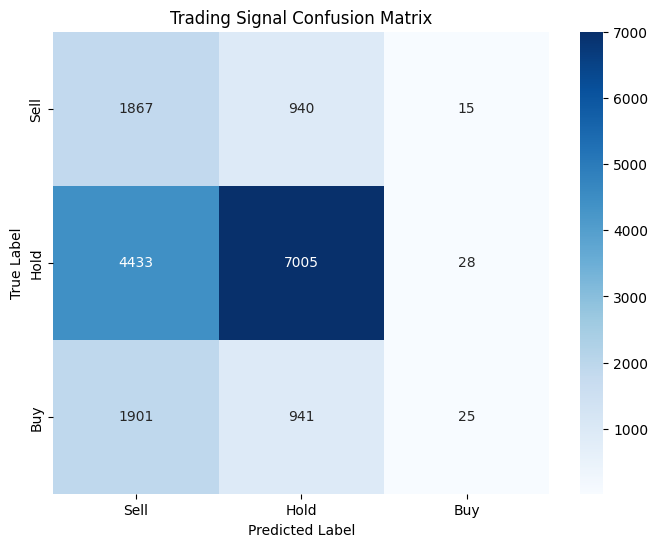

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Basic evaluation
test_loss, test_accuracy = trading_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Detailed predictions
y_pred = trading_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

trading_model.save("../models/trading_signals_model.h5")
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                          target_names=['Sell', 'Hold', 'Buy']))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sell', 'Hold', 'Buy'],
            yticklabels=['Sell', 'Hold', 'Buy'])
plt.title('Trading Signal Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 10. Plot Training History

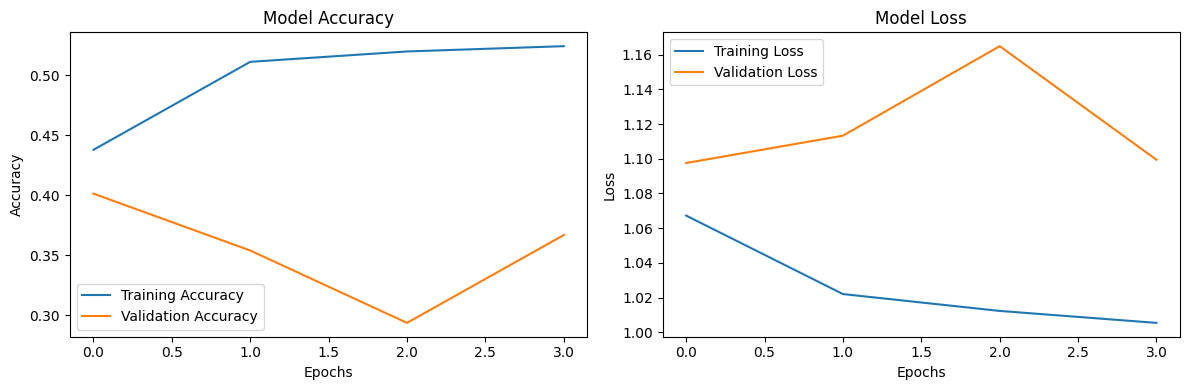

In [26]:
plt.figure(figsize=(12, 4))

# Plot training history
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.tight_layout()
plt.show()

# 11. Walk-Forward Validation (Optional - Better than Single Split)

In [ ]:
def walk_forward_validation(x_data, y_data, model_builder, n_splits=5):
    """
    Perform walk-forward validation for time series data
    Better than random split as it respects temporal order
    """
    total_samples = len(x_data)
    split_size = total_samples // n_splits
    
    accuracies = []
    
    for i in range(n_splits - 1):
        # Progressive training set (expanding window)
        train_end = (i + 2) * split_size
        test_start = train_end
        test_end = test_start + split_size
        
        # Split data
        x_train_fold = x_data[:train_end]
        y_train_fold = y_data[:train_end]
        x_test_fold = x_data[test_start:test_end]
        y_test_fold = y_data[test_start:test_end]
        
        print(f"\nFold {i+1}:")
        print(f"Train: 0 to {train_end} ({len(x_train_fold)} samples)")
        print(f"Test: {test_start} to {test_end} ({len(x_test_fold)} samples)")
        
        # Build and train model
        model = model_builder(x_train_fold.shape[1:])
        
        # Class weights for this fold
        fold_class_weights = compute_class_weight('balanced', 
                                                classes=np.unique(y_train_fold), 
                                                y=y_train_fold)
        fold_class_weight_dict = dict(enumerate(fold_class_weights))
        
        # Train model
        model.fit(x_train_fold, y_train_fold,
                 validation_split=0.2,
                 epochs=30,  # Reduced for faster validation
                 batch_size=64,
                 class_weight=fold_class_weight_dict,
                 verbose=0)
        
        # Evaluate
        _, accuracy = model.evaluate(x_test_fold, y_test_fold, verbose=0)
        accuracies.append(accuracy)
        print(f"Fold {i+1} accuracy: {accuracy:.4f}")
    
    return accuracies

def create_cnn_lstm_model(input_shape, 
                         sequence_length=20, 
                         kernel_size=5, 
                         lstm_units=64):
    """Model builder function for walk-forward validation"""
    inputs = layers.Input(shape=input_shape)
    
    # Multi-scale CNN
    conv1 = layers.Conv1D(32, 3, activation='relu', padding='same')(inputs)
    conv2 = layers.Conv1D(32, kernel_size, activation='relu', padding='same')(inputs)
    conv3 = layers.Conv1D(32, 7, activation='relu', padding='same')(inputs)
    
    x = layers.Concatenate()([conv1, conv2, conv3])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv1D(64, kernel_size, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    # LSTM layers
    x = layers.LSTM(lstm_units, return_sequences=True, dropout=0.3)(x)
    x = layers.LSTM(lstm_units//2, dropout=0.3)(x)
    
    # Dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Run walk-forward validation (uncomment to run)
print("Running walk-forward validation...")
wf_accuracies = walk_forward_validation(x_trading_seq, y_trading_aligned, create_cnn_lstm_model)
print(f"\nWalk-forward validation results:")
print(f"Mean accuracy: {np.mean(wf_accuracies):.4f} ± {np.std(wf_accuracies):.4f}")
print(f"Individual fold accuracies: {wf_accuracies}")

print("Walk-forward validation function defined. Uncomment to run.")

Running walk-forward validation...

Fold 1:
Train: 0 to 34308 (34308 samples)
Test: 34308 to 51462 (17154 samples)
Fold 1 accuracy: 0.5783

Fold 2:
Train: 0 to 51462 (51462 samples)
Test: 51462 to 68616 (17154 samples)
